# Long short-term memory

**Topic**: Web Traffic Time Series Forecasting: Forecast future traffic to Wikipedia pages
<br>
**Author**: Devanshi Verma
<br>
**Class**: MSCA 31006 TimeSeries Analysis
<br>
**Professor**: Dr. Shaddy Abado
<br>
**Idea**: This competition focuses on the problem of forecasting the future values of multiple time series, as it has always been one of the most challenging problems in the field. 
<br>
**Link**: https://www.kaggle.com/c/web-traffic-time-series-forecasting/overview


**Table of contents**

1. Overview
2. Importing the libraries
3. Dataset
4. Dataset preperation
5. Visualization
6. Modeling

### 1. Overview

**Description**
We decided to work on one of the most burning time series problem of today’s day and era, “predicting web traffic”. We believe that this forecasting can help website servers a great deal in effectively handling outages. The technique we implemented can be extended to diverse applications in financial markets, weather forecasts, audio and video processing. Not just that, understanding your website’s traffic trajectory can open up business opportunities too!


**Dataset**
The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. The leaderboard during the training stage is based on traffic from January, 1st, 2017 up until March 1st, 2017.

The second stage will use training data up until September 1st, 2017. The final ranking of the competition will be based on predictions of daily views between September 13th, 2017 and November 13th, 2017 for each article in the dataset. You will submit your forecasts for these dates by September 12th.

### 2. Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Set additional parameters for charts and tables
# Remove column display limits
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-whitegrid')

In [3]:
#setting up the seed for reproducibility
np.random.seed(42)

### 3. Dataset

In [4]:
#change the datapath as per in your machine to the folder containing all the datasets
datapath="/Users/devanshiverma/Desktop/UChicago/Quarters/03-Quarters/Data/TS/web-traffic-time-series-forecasting"
key_1=pd.read_csv(datapath+"/key_1.csv")
key_1.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [5]:
key_2=pd.read_csv(datapath+"/key_2.csv")
key_2.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


In [6]:
sample_submission_1=pd.read_csv(datapath+"/sample_submission_1.csv")
sample_submission_1.head()

,Id,Visits
0,bf4edcf969af,0
1,929ed2bf52b9,0
2,ff29d0f51d5c,0
3,e98873359be6,0
4,fa012434263a,0


In [7]:
sample_submission_2=pd.read_csv(datapath+"/sample_submission_2.csv")
sample_submission_2.head()

,Id,Visits
0,0b293039387a,0
1,7114389dd824,0
2,057b02ff1f09,0
3,bd2aca21caa3,0
4,c0effb42cdd5,0


In [8]:
train_1=pd.read_csv(datapath+"/train_1.csv")
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

In [9]:
train_2=pd.read_csv(datapath+"/train_2.csv")
train_2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

### 4. Data Preperation

**Shape of the data**

In [61]:
print("The train 1 is {}".format(train_1.shape))
print("The train 2 is {}".format(train_2.shape))

The train 1 is (145063, 551)
The train 2 is (145063, 804)


**Looking at the null values**

In [62]:
#% null values in the dataset
(train_1.isnull().sum()/train_1.shape[0])*100

Page           0.000000
2015-07-01    14.297236
2015-07-02    14.349627
2015-07-03    14.162123
2015-07-04    14.237952
2015-07-05    14.241399
2015-07-06    14.120072
2015-07-07    14.244845
2015-07-08    13.989784
2015-07-09    13.955316
2015-07-10    14.022873
2015-07-11    14.149025
2015-07-12    14.121451
2015-07-13    14.062166
2015-07-14    13.883623
2015-07-15    13.860185
2015-07-16    13.778152
2015-07-17    13.820202
2015-07-18    13.990473
2015-07-19    13.885002
2015-07-20    13.772637
2015-07-21    13.572034
2015-07-22    13.492758
2015-07-23    13.498273
2015-07-24    13.506545
2015-07-25    13.503788
2015-07-26    13.694050
2015-07-27    13.620978
2015-07-28    13.478971
2015-07-29    13.336964
2015-07-30    13.505856
2015-07-31    13.585821
2015-08-01    13.538945
2015-08-02    13.679574
2015-08-03    13.678195
2015-08-04    13.507924
2015-08-05    13.516196
2015-08-06    13.390044
2015-08-07    13.461737
2015-08-08    13.459669
2015-08-09    13.318351
2015-08-10    13

- Every column has around 2-14% missing values but let's see for the dates

In [63]:
#% null values in the dataset
(sum((train_1.isnull().sum(axis=1))==0)/train_1.shape[0])*100

80.8455636516548

- **WAY1** :80% of the rows are fully populated. So let's take these rows for the analysis right now

In [64]:
#Way1
#index of the rows considered 
#indexes=(train_1.isnull().sum(axis=1))
#new_train_1=train_1.loc[indexes,:]
#new_train_1.head()

- Since, we need all the pages for prediction we just make the visit 0

In [65]:
new_train_1=train_1.fillna(0)
#% null values in the dataset are
print("The NULL values are "+ str(sum((new_train_1.isnull().sum()))))
new_train_1.head()

The NULL values are 0


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

**Restructuring the dataframe**

In [66]:
#starting by plotting the time series for a few websites
new_train1_melted=pd.melt(new_train_1,id_vars='Page', var_name='date', value_name='Visits')
new_train1_melted.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [67]:
#converting the dates into date time format
new_train1_melted['date'] = pd.to_datetime(new_train1_melted.date)
new_train1_melted.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


### 5. Visualization

**Total Views by days**

In [17]:
Aggregated_data=new_train1_melted.groupby(['date'])['Visits'].sum()

Text(0.5, 1.0, 'Total Views on Wikipedia pages V/S dates')

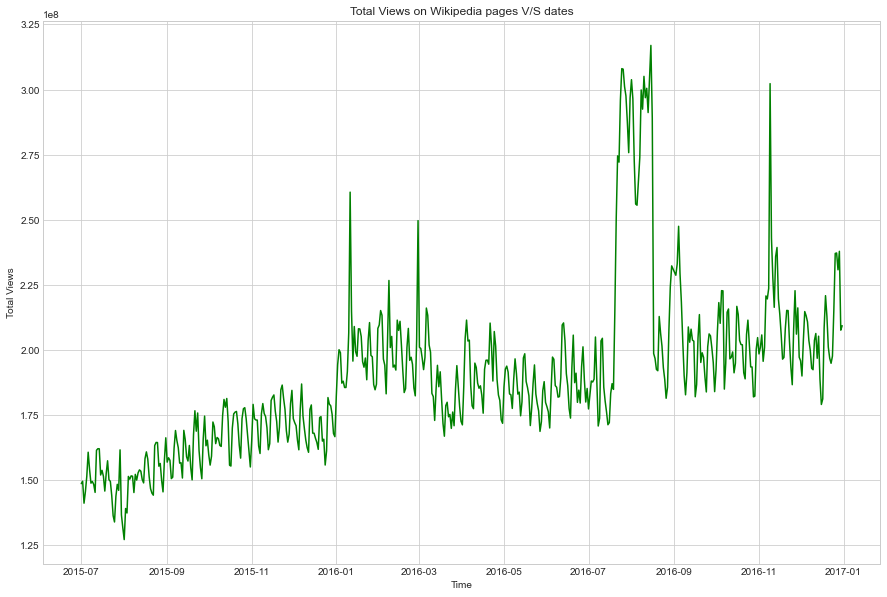

In [18]:
plt.plot(Aggregated_data,'g')
plt.xlabel('Time')
plt.ylabel('Total Views')
plt.title('Total Views on Wikipedia pages V/S dates')

- The time series is not stationary but infact it's seasonal, with increasing trend, high varaince in values

**Mean Views by days**

Text(0.5, 1.0, 'Mean Views on Wikipedia pages V/S dates')

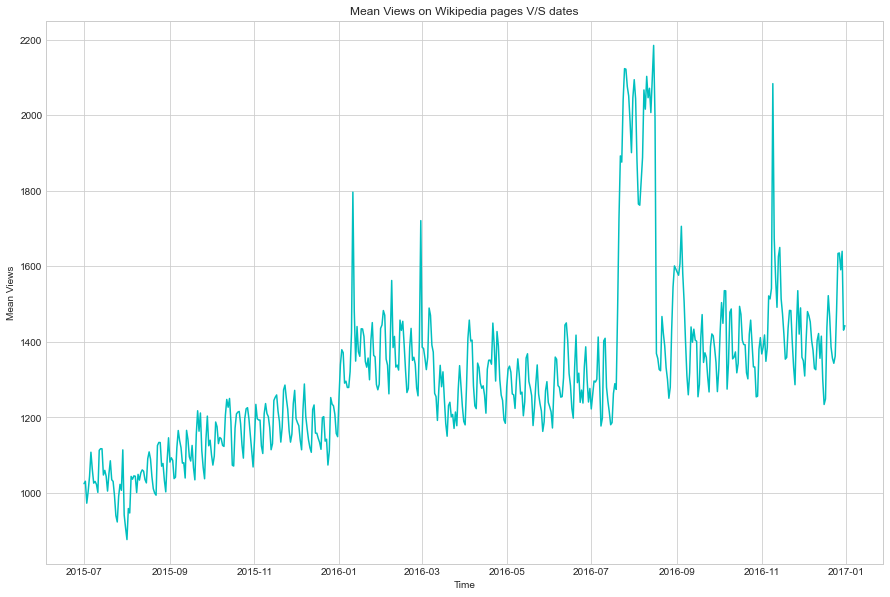

In [19]:
Aggregated_data=new_train1_melted.groupby(['date'])['Visits'].mean()
plt.plot(Aggregated_data,'c')
plt.xlabel('Time')
plt.ylabel('Mean Views')
plt.title('Mean Views on Wikipedia pages V/S dates')

- The time series is not stationary but infact it's seasonal, with increasing trend, high varaince in values

**Median Views**

Text(0.5, 1.0, 'Median Views on Wikipedia pages V/S dates')

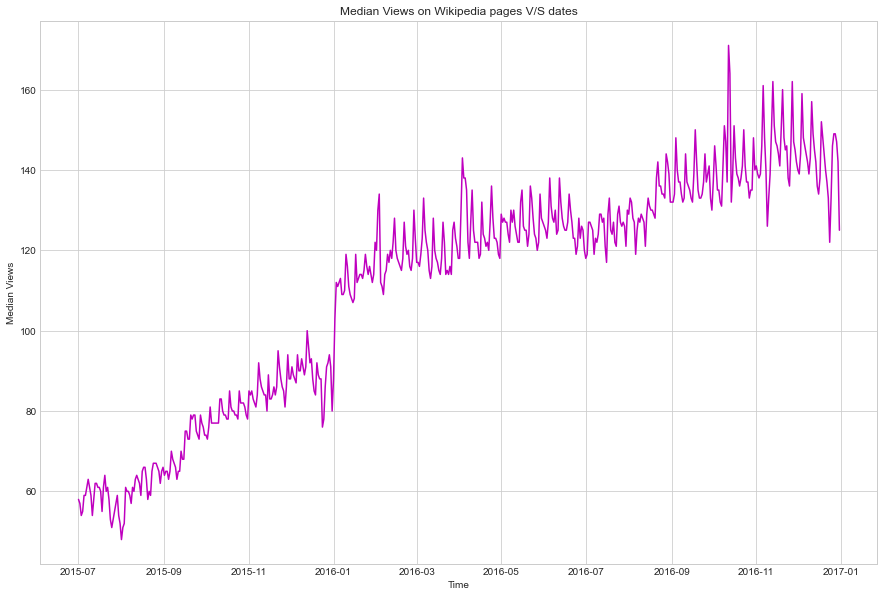

In [19]:
Aggregated_data=new_train1_melted.groupby(['date'])['Visits'].median()
plt.plot(Aggregated_data,'m')
plt.xlabel('Time')
plt.ylabel('Median Views')
plt.title('Median Views on Wikipedia pages V/S dates')

- The time series is not stationary but infact it's seasonal, with increasing trend, lesser varaince in values

**Traffic' Dependency on Page's Language**

The pages are labeled as "en.wikipedia.org" and zh.wikipedia.org which tells us that the language is `en` and `zh`. Therefore, we need to extract these values to find out views by language

In [72]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'
new_train1_melted['lang'] = new_train1_melted.Page.map(get_language)

In [76]:
new_train1_melted.head()

,Page,date,Visits,lang
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,zh
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,zh


In [77]:
#grouping by language
Aggregated_data=new_train1_melted.groupby(['date','lang'])['Visits'].sum()
Aggregated_data=Aggregated_data.reset_index()
#restructuring for plotting
Aggregated_data_melted=Aggregated_data.pivot(index='date', columns='lang', values='Visits')

date        lang
2015-07-01  de      13260519.0
            en      84712190.0
            es      15278553.0
            fr       8458638.0
            ja      11863200.0
Name: Visits, dtype: float64

In [94]:
Aggregated_data_melted.head()

lang,de,en,es,fr,ja,na,ru,zh
date,,,,,,,,
2015-07-01,13260519.0,84712190.0,15278553.0,8458638.0,11863200.0,1490534.0,9463854.0,4144988.0
2015-07-02,13079896.0,84438545.0,14601013.0,8512952.0,13620792.0,1561810.0,9627643.0,4151189.0
2015-07-03,12554042.0,80167728.0,13427632.0,8186030.0,12305383.0,1476261.0,8923463.0,4123659.0
2015-07-04,11520379.0,83463204.0,12606538.0,8749842.0,15456239.0,1260073.0,8393214.0,4163448.0
2015-07-05,13392347.0,86198637.0,13710356.0,8590493.0,14827204.0,1396521.0,8938528.0,4441286.0


Text(0.5, 1.0, 'Pages in Different Languages')

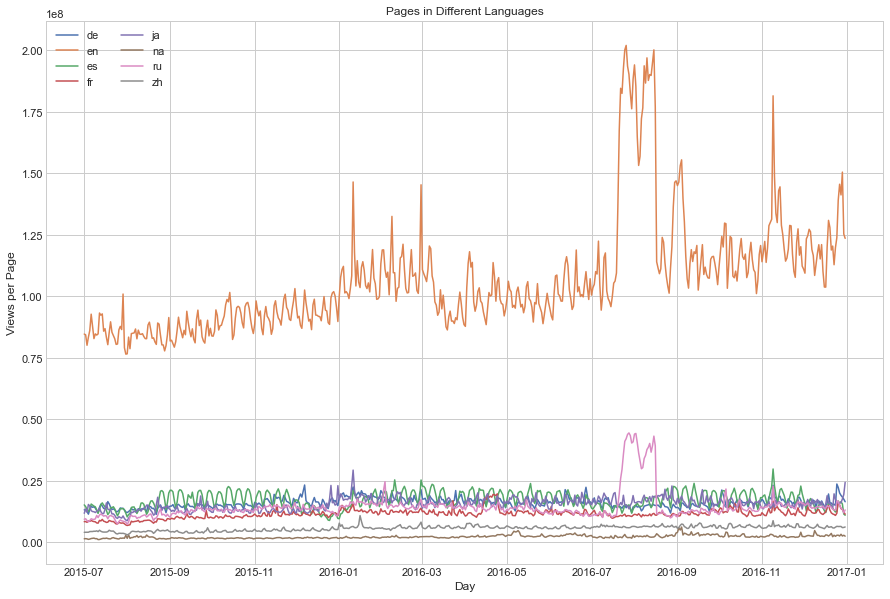

In [103]:
plt.plot(Aggregated_data_melted)
plt.legend(Aggregated_data_melted.columns, ncol=2, loc='upper left');
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')

We can see from the above graph that different language pages have different views
- English language has the maximum views followed by es. There are two reasons for it's popularity. First, wikipedia is a US based site, second language base for english i.e. number of people using english is way more that the other languages
- Interestingly there's a spike in page views for US and Russia in July 2016 and September 2016. 

### 6a. Modeling for FIFA world cup

Let's have a look at the time series 

LSTM is a recurrent neural network (RNN) architecture that REMEMBERS values over arbitrary intervals. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. Relative insensitivity to gap length gives an advantage to LSTM over alternative RNNs, hidden Markov models and other sequence learning methods. They also solve the problem of vanishing gradients

<img src ="https://miro.medium.com/max/1400/1*SAuwuiKBhzR4tBhr54mYkA.png">

The structure of RNN is very similar to hidden Markov model. However, the main difference is with how parameters are calculated and constructed. One of the advantage with LSTM is insensitivity to gap length. RNN and HMM rely on the hidden state before emission / sequence. If we want to predict the sequence after 1,000 intervals instead of 10, the model forgot the starting point by then. LSTM REMEMBERS.

<img src ="https://miro.medium.com/max/1084/1*ULozye1lfd-dS9RSwndZdw.png">

- The long-term memory is usually called the **cell state**. The looping arrows indicate recursive nature of the cell.This allows information from previous intervals to be stored with in the LSTM cell
- The remember vector is usually called the **forget gate**. The output of the forget gate tells the cell state which information to forget by multiplying 0 to a position in the matrix. Sigmoid function is applied to the weighted input/observation and previous hidden state.
- The save vector is usually called the **input gate.** These gates determine which information should enter the cell state / long-term memory. The input gate is a sigmoid function and have a range of [0,1]. We can only add a float number between [0,1] to modulate input, that number will never be zero / turned-off / forget. This is why the input modulation gate has an tanh activation function. Tanh has a range of [-1, 1] and allows the cell state to forget memory.
- The focus vector is usually called the **output gate.** Out of all the possible values from the matrix, which should be moving forward to the next hidden state? Even this uses sigmoid to highlight which information should be going to the next hidden state.
- The working memory is usually called the **hidden state.** What information should I take to the next sequence? This is analogous to the hidden state in RNN and HMM.

**Source** :https://medium.com/@kangeugine/long-short-term-memory-lstm-concept-cb3283934359

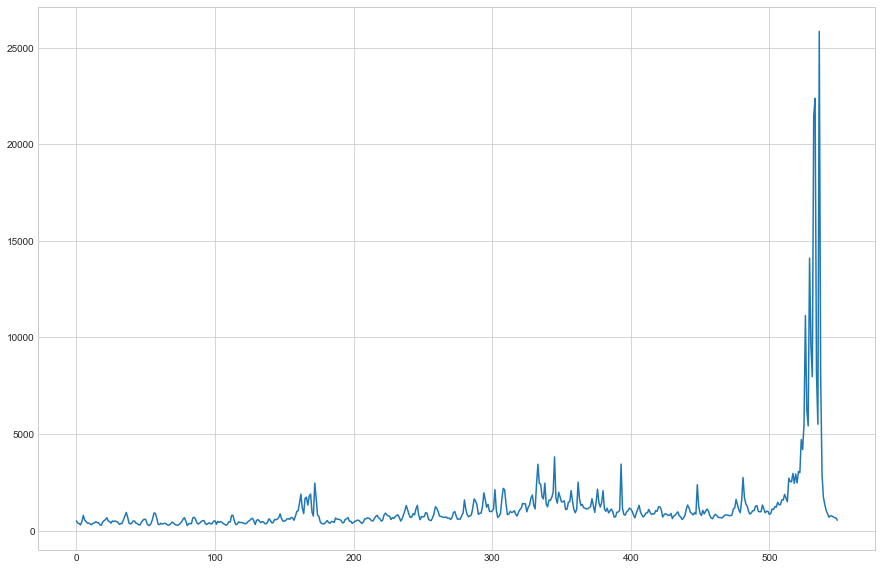

In [46]:
LSTM_input=train_1.iloc[8393,:]
plt.plot(LSTM_input[1:].values)

In [47]:
#lets take out the values
LSTM_input=train_1.iloc[8393,:].values
LSTM_input=LSTM_input[1:]
#let's find the number of observations
len(LSTM_input)

550

In [48]:
#defining the min and max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
#changing the shape of the dataset
LSTM_input = np.reshape(LSTM_input,(-1,1))
#transforming
dataset = scaler.fit_transform(LSTM_input)

Let's configure this dataset like if at time `t` we are predicting for `t+1`

In [49]:
#splitting the dataset into test and train 
train_size=int(len(dataset)*0.67)
test_size=len(dataset)-train_size
train_df=dataset[0:train_size,:]
test_df=dataset[train_size:len(dataset),:]
print(train_size,test_size)
print(len(train_df),len(test_df))

368 182
368 182


In [50]:
#taking previous units
def restructure_ts_data(data,previous_vals):
    dataX, dataY = [], []
    for i in range(len(data)-previous_vals-1):
        dataX.append(data[i:i+previous_vals,0])
        dataY.append(data[i + previous_vals, 0])
    return np.array(dataX),np.array(dataY)

In [51]:
X_train,y_train=restructure_ts_data(train_df,1)
X_test,y_test=restructure_ts_data(test_df,1)

In [52]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(366, 1) (366,) (180, 1) (180,)


In [53]:
#resizing the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [54]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(366, 1, 1) (366,) (180, 1, 1) (180,)


In [55]:
#let's build the model

ts=Sequential()

#adding a lstm layer with 12 nodes and relu activation function
ts.add(LSTM(units=12,activation='relu',input_shape=(None,1)))



#adding the output layer
ts.add(Dense(units=1))

#compiling the RNN
ts.compile(optimizer = 'adam', loss = 'mean_squared_error')

ts.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)


Epoch 1/100
37/37 - 0s - loss: 5.3221e-04
Epoch 2/100
37/37 - 0s - loss: 4.0776e-04
Epoch 3/100
37/37 - 0s - loss: 4.1094e-04
Epoch 4/100
37/37 - 0s - loss: 4.0969e-04
Epoch 5/100
37/37 - 0s - loss: 3.9924e-04
Epoch 6/100
37/37 - 0s - loss: 3.9286e-04
Epoch 7/100
37/37 - 0s - loss: 3.9395e-04
Epoch 8/100
37/37 - 0s - loss: 3.9115e-04
Epoch 9/100
37/37 - 0s - loss: 3.8610e-04
Epoch 10/100
37/37 - 0s - loss: 3.7901e-04
Epoch 11/100
37/37 - 0s - loss: 3.7635e-04
Epoch 12/100
37/37 - 0s - loss: 3.7099e-04
Epoch 13/100
37/37 - 0s - loss: 3.6599e-04
Epoch 14/100
37/37 - 0s - loss: 3.6216e-04
Epoch 15/100
37/37 - 0s - loss: 3.4869e-04
Epoch 16/100
37/37 - 0s - loss: 3.4573e-04
Epoch 17/100
37/37 - 0s - loss: 3.3501e-04
Epoch 18/100
37/37 - 0s - loss: 3.2474e-04
Epoch 19/100
37/37 - 0s - loss: 3.1594e-04
Epoch 20/100
37/37 - 0s - loss: 3.0717e-04
Epoch 21/100
37/37 - 0s - loss: 2.9679e-04
Epoch 22/100
37/37 - 0s - loss: 2.9251e-04
Epoch 23/100
37/37 - 0s - loss: 2.7984e-04
Epoch 24/100
37/37 -

In [56]:
trainPredict = ts.predict(X_train)
testPredict = ts.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

In [57]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 307.44 RMSE


In [58]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2779.06 RMSE


Text(0.5, 0, 'Days')

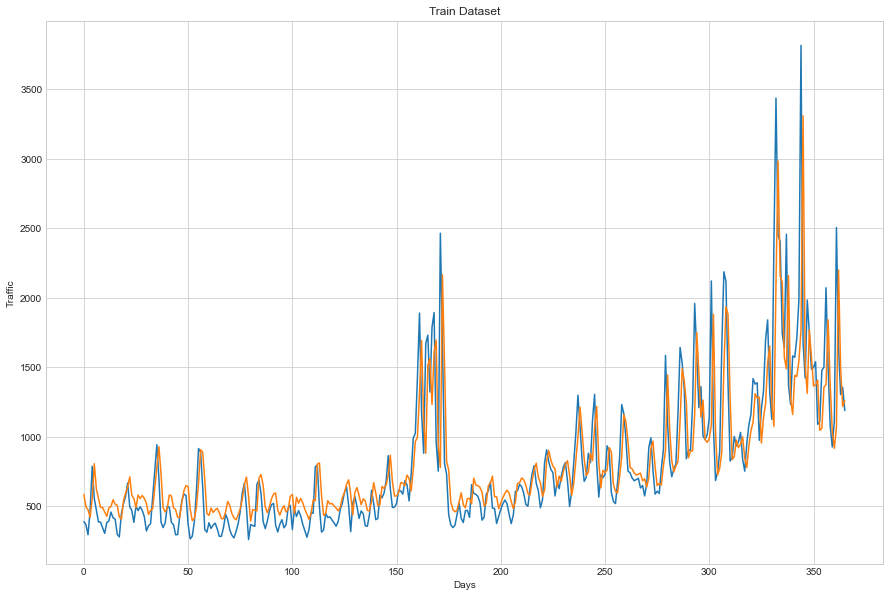

In [59]:
LL=trainY.T
fig, ax = plt.subplots()
ax.plot(LL)
ax.plot(trainPredict)
plt.title("Train Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

Text(0.5, 0, 'Days')

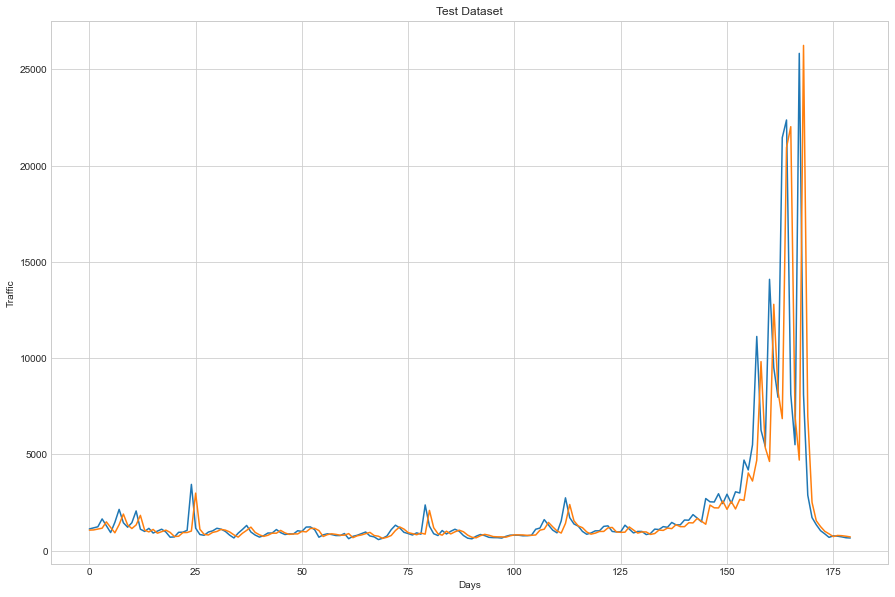

In [60]:
LL3=testY.T
fig, ax = plt.subplots()
ax.plot(LL3)
ax.plot(testPredict)
plt.title("Test Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

### 6b. Modeling for Summer RIO Olympics

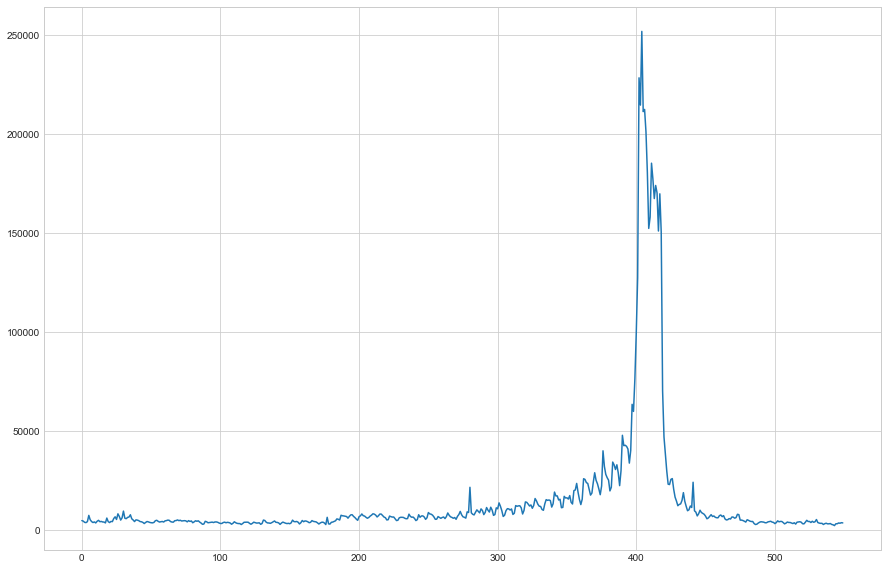

In [10]:
LSTM_input=train_1.iloc[12186,:]
plt.plot(LSTM_input[1:].values)

In [11]:
#lets take out the values
LSTM_input=train_1.iloc[12186,:].values
LSTM_input=LSTM_input[1:]
#let's find the number of observations
len(LSTM_input)

550

In [12]:
#defining the min and max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
#changing the shape of the dataset
LSTM_input = np.reshape(LSTM_input,(-1,1))
#transforming
dataset = scaler.fit_transform(LSTM_input)

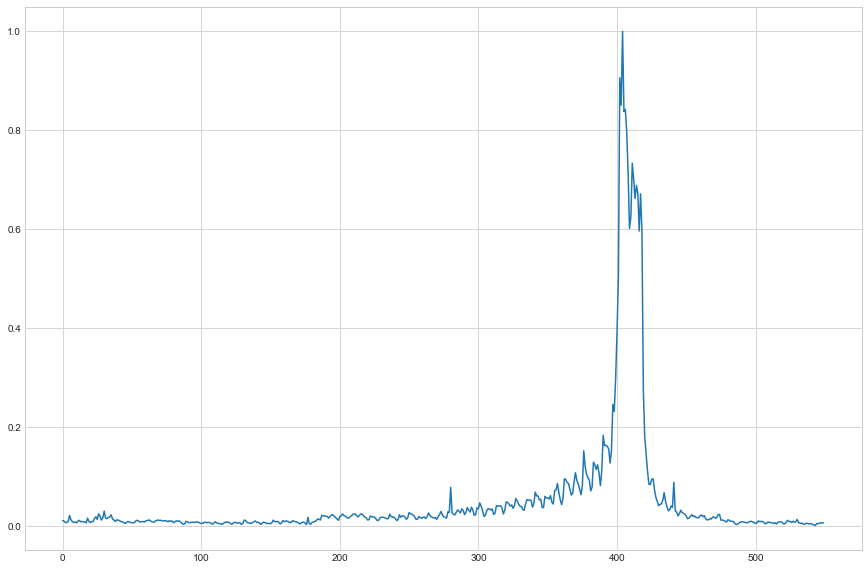

In [13]:
#let's have look at the dataset again
plt.plot(dataset)

In [14]:
#splitting the dataset into test and train 
train_df=dataset[0:520,:]
test_df=dataset[520:,:]
print(len(train_df),len(test_df))

520 30


In [15]:
#taking previous units
def restructure_ts_data(data,previous_vals):
    dataX, dataY = [], []
    for i in range(len(data)-previous_vals-1):
        dataX.append(data[i:i+previous_vals,0])
        dataY.append(data[i + previous_vals, 0])
    return np.array(dataX),np.array(dataY)

In [16]:
X_train,y_train=restructure_ts_data(train_df,1)
X_test,y_test=restructure_ts_data(test_df,1)

In [17]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(518, 1) (518,) (28, 1) (28,)


In [18]:
#resizing the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(518, 1, 1) (518,) (28, 1, 1) (28,)


In [20]:
#let's build the model

ts=Sequential()

# Adding the input layerand the LSTM layer
ts.add(LSTM(units = 8, activation = 'relu', input_shape = (1, 1)))



#adding the output layer
ts.add(Dense(units=1))

#compiling the RNN
ts.compile(optimizer = 'adam', loss = 'mean_squared_error')

ts.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)


Epoch 1/100
52/52 - 0s - loss: 0.0164
Epoch 2/100
52/52 - 0s - loss: 0.0147
Epoch 3/100
52/52 - 0s - loss: 0.0138
Epoch 4/100
52/52 - 0s - loss: 0.0129
Epoch 5/100
52/52 - 0s - loss: 0.0119
Epoch 6/100
52/52 - 0s - loss: 0.0107
Epoch 7/100
52/52 - 0s - loss: 0.0096
Epoch 8/100
52/52 - 0s - loss: 0.0083
Epoch 9/100
52/52 - 0s - loss: 0.0070
Epoch 10/100
52/52 - 0s - loss: 0.0057
Epoch 11/100
52/52 - 0s - loss: 0.0046
Epoch 12/100
52/52 - 0s - loss: 0.0036
Epoch 13/100
52/52 - 0s - loss: 0.0028
Epoch 14/100
52/52 - 0s - loss: 0.0023
Epoch 15/100
52/52 - 0s - loss: 0.0019
Epoch 16/100
52/52 - 0s - loss: 0.0015
Epoch 17/100
52/52 - 0s - loss: 0.0013
Epoch 18/100
52/52 - 0s - loss: 0.0012
Epoch 19/100
52/52 - 0s - loss: 0.0011
Epoch 20/100
52/52 - 0s - loss: 0.0011
Epoch 21/100
52/52 - 0s - loss: 0.0011
Epoch 22/100
52/52 - 0s - loss: 0.0011
Epoch 23/100
52/52 - 0s - loss: 0.0011
Epoch 24/100
52/52 - 0s - loss: 0.0011
Epoch 25/100
52/52 - 0s - loss: 0.0011
Epoch 26/100
52/52 - 0s - loss: 0.

In [21]:
trainPredict = ts.predict(X_train)
testPredict = ts.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

In [22]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 7911.74 RMSE


In [23]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 618.62 RMSE


Text(0.5, 0, 'Days')

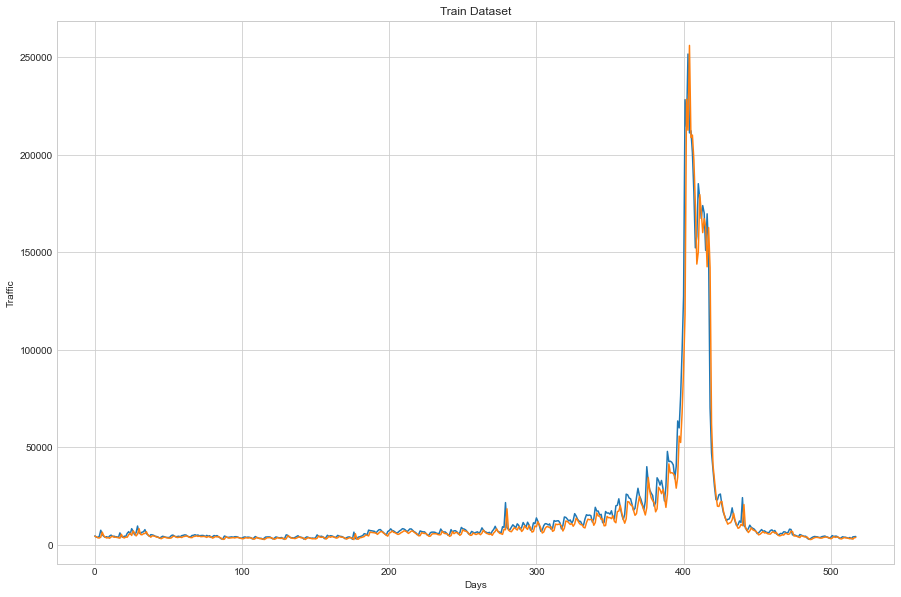

In [24]:
LL=trainY.T
fig, ax = plt.subplots()
ax.plot(LL)
ax.plot(trainPredict)
plt.title("Train Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

Text(0.5, 0, 'Days')

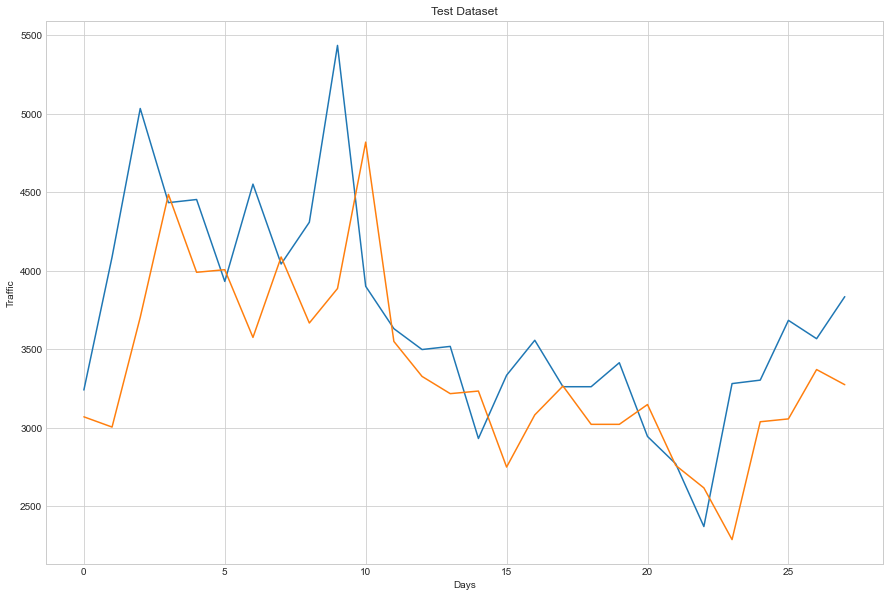

In [26]:
LL3=testY.T
fig, ax = plt.subplots()
ax.plot(LL3)
ax.plot(testPredict)
plt.title("Test Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

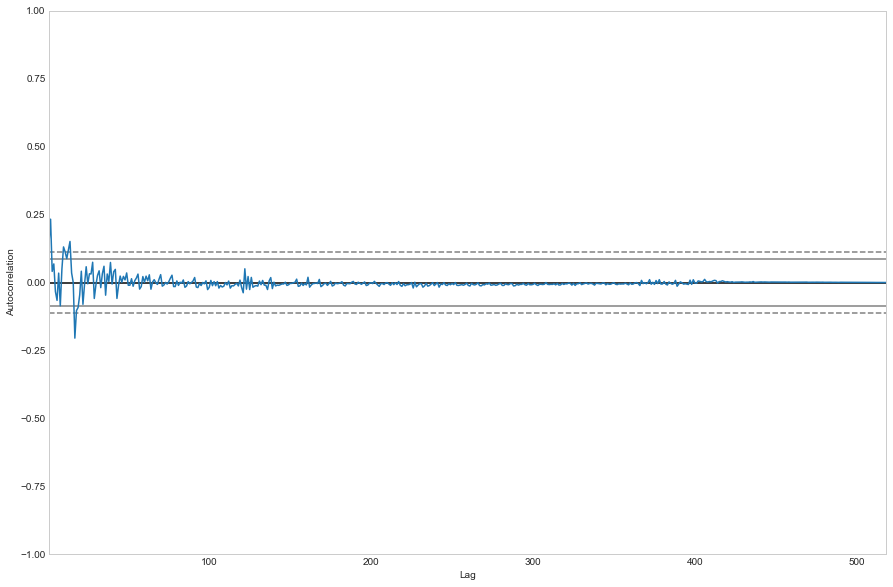

In [30]:
from pandas.plotting import autocorrelation_plot
residuals=LL-trainPredict
autocorrelation_plot(residuals)
plt.show()

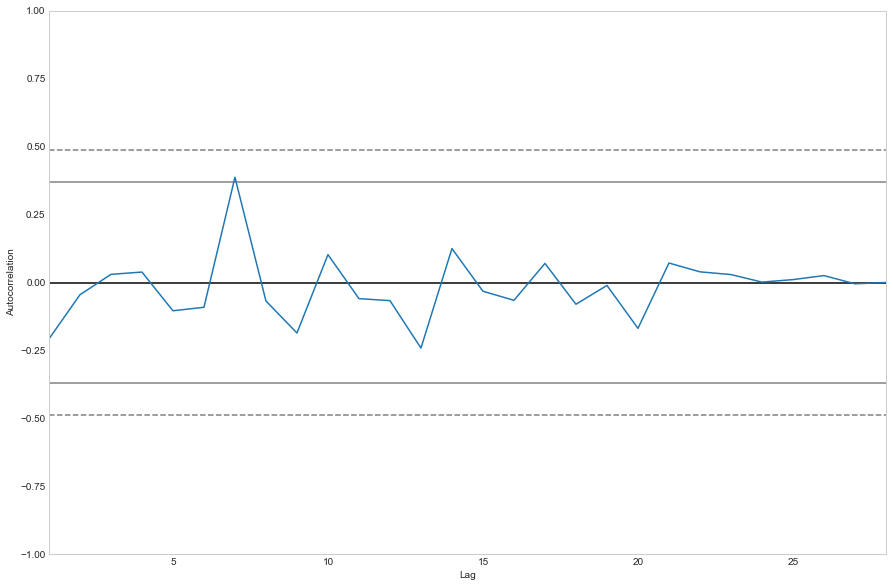

In [31]:
from pandas.plotting import autocorrelation_plot
residuals=LL3-testPredict
autocorrelation_plot(residuals)
plt.show()

**Let's change the window size**

In [379]:
X_train,y_train=restructure_ts_data(train_df,3)
X_test,y_test=restructure_ts_data(test_df,3)

In [380]:
X_train[1:5]

array([[0.00902147, 0.00653555, 0.00603035],
       [0.00653555, 0.00603035, 0.00807923],
       [0.00603035, 0.00807923, 0.02064514],
       [0.00807923, 0.02064514, 0.01182013]])

In [381]:
y_train[1:5]

array([0.00807923, 0.02064514, 0.01182013, 0.00821154])

In [382]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(516, 3) (516,) (26, 3) (26,)


In [383]:
#resizing the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [376]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(516, 1, 3) (516,) (26, 1, 3) (26,)


In [378]:
#let's build the model

ts=Sequential()

# Adding the input layerand the LSTM layer
ts.add(LSTM(units = 8, activation = 'relu', input_shape = (3, 1)))



#adding the output layer
ts.add(Dense(units=1))

#compiling the RNN
ts.compile(optimizer = 'adam', loss = 'mean_squared_error')

ts.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)


Epoch 1/100


ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential_34: expected shape=(None, None, 1), found shape=[None, 1, 3]


In [332]:
trainPredict = ts.predict(X_train)
testPredict = ts.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

In [333]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 7811.16 RMSE


In [334]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1152.71 RMSE


Text(0.5, 0, 'Days')

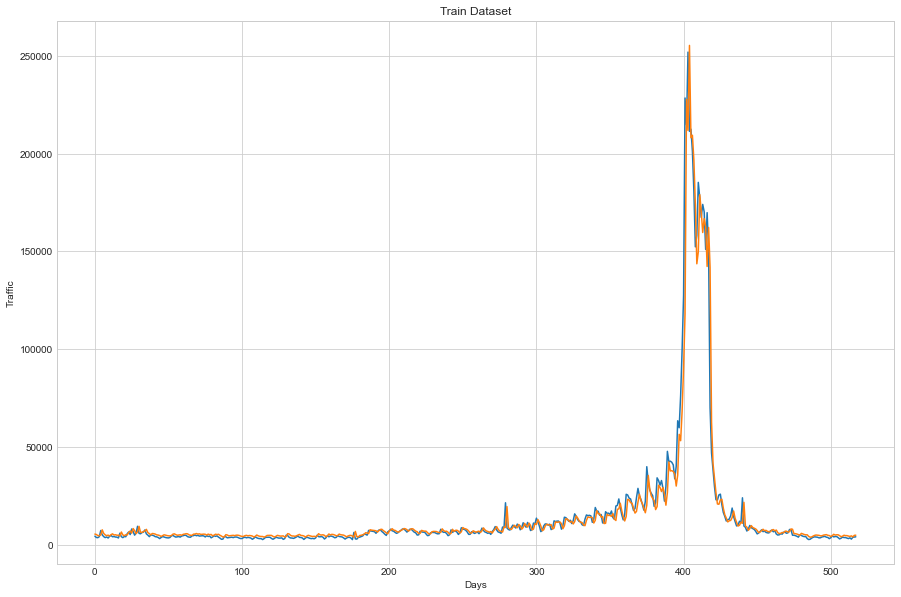

In [335]:
LL=trainY.T
fig, ax = plt.subplots()
ax.plot(LL)
ax.plot(trainPredict)
plt.title("Train Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

Text(0.5, 0, 'Days')

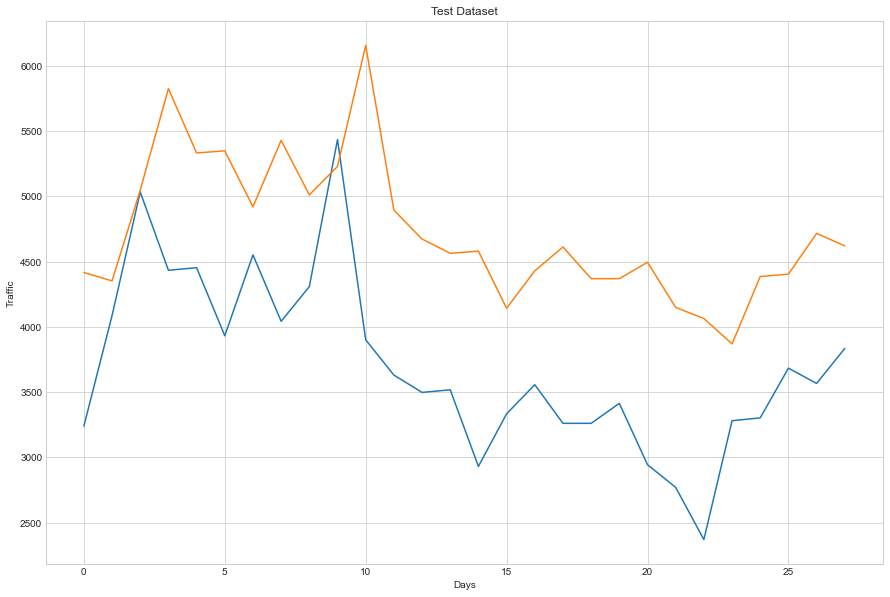

In [336]:
LL3=testY.T
fig, ax = plt.subplots()
ax.plot(LL3)
ax.plot(testPredict)
plt.title("Test Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

### 6c. Modeling for 加权平均资本成本 page

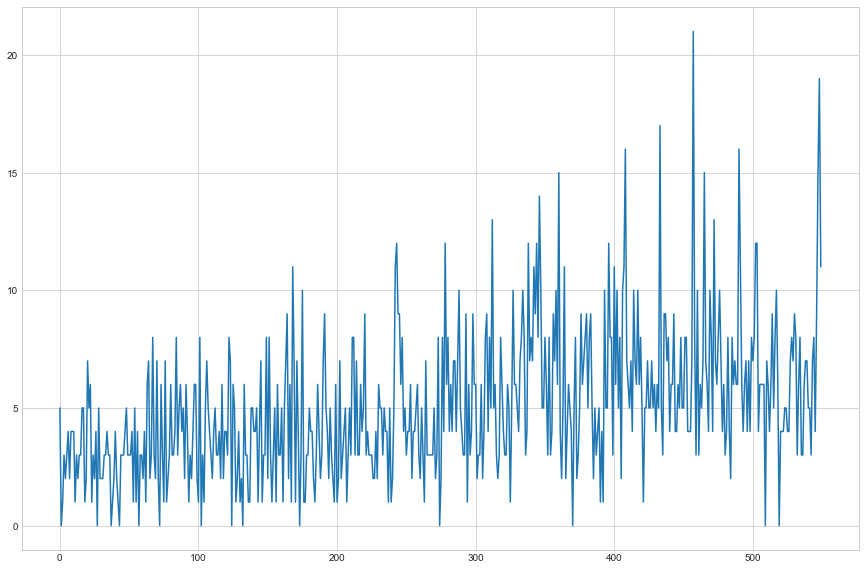

In [28]:
LSTM_input=train_1[train_1['Page']=='加权平均资本成本_zh.wikipedia.org_all-access_spider']
LSTM_input=LSTM_input.iloc[:,1:].T
plt.plot(LSTM_input.values)

In [29]:
len(LSTM_input)

550

In [30]:
#defining the min and max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
#changing the shape of the dataset
LSTM_input = np.reshape(LSTM_input,(-1,1))
#transforming
dataset = scaler.fit_transform(LSTM_input)

In [31]:
#splitting the dataset into test and train 
train_size=int(len(dataset)*0.67)
test_size=len(dataset)-train_size
train_df=dataset[0:train_size,:]
test_df=dataset[train_size:len(dataset),:]
print(train_size,test_size)
print(len(train_df),len(test_df))

368 182
368 182


In [32]:
#taking previous units
def restructure_ts_data(data,previous_vals):
    dataX, dataY = [], []
    for i in range(len(data)-previous_vals-1):
        dataX.append(data[i:i+previous_vals,0])
        dataY.append(data[i + previous_vals, 0])
    return np.array(dataX),np.array(dataY)

In [33]:
X_train,y_train=restructure_ts_data(train_df,1)
X_test,y_test=restructure_ts_data(test_df,1)

In [34]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(366, 1) (366,) (180, 1) (180,)


In [35]:
#resizing the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [36]:
print("Let's have a look at the shapes")
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Let's have a look at the shapes
(366, 1, 1) (366,) (180, 1, 1) (180,)


In [37]:
#let's build the model

ts=Sequential()

#adding a lstm layer with 12 nodes and relu activation function
ts.add(LSTM(units=12,activation='relu',input_shape=(None,1)))



#adding the output layer
ts.add(Dense(units=1))

#compiling the RNN
ts.compile(optimizer = 'adam', loss = 'mean_squared_error')

ts.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)


Epoch 1/100
37/37 - 0s - loss: 0.0451
Epoch 2/100
37/37 - 0s - loss: 0.0276
Epoch 3/100
37/37 - 0s - loss: 0.0190
Epoch 4/100
37/37 - 0s - loss: 0.0161
Epoch 5/100
37/37 - 0s - loss: 0.0157
Epoch 6/100
37/37 - 0s - loss: 0.0157
Epoch 7/100
37/37 - 0s - loss: 0.0157
Epoch 8/100
37/37 - 0s - loss: 0.0156
Epoch 9/100
37/37 - 0s - loss: 0.0156
Epoch 10/100
37/37 - 0s - loss: 0.0157
Epoch 11/100
37/37 - 0s - loss: 0.0156
Epoch 12/100
37/37 - 0s - loss: 0.0157
Epoch 13/100
37/37 - 0s - loss: 0.0158
Epoch 14/100
37/37 - 0s - loss: 0.0158
Epoch 15/100
37/37 - 0s - loss: 0.0157
Epoch 16/100
37/37 - 0s - loss: 0.0157
Epoch 17/100
37/37 - 0s - loss: 0.0156
Epoch 18/100
37/37 - 0s - loss: 0.0157
Epoch 19/100
37/37 - 0s - loss: 0.0157
Epoch 20/100
37/37 - 0s - loss: 0.0156
Epoch 21/100
37/37 - 0s - loss: 0.0156
Epoch 22/100
37/37 - 0s - loss: 0.0156
Epoch 23/100
37/37 - 0s - loss: 0.0157
Epoch 24/100
37/37 - 0s - loss: 0.0156
Epoch 25/100
37/37 - 0s - loss: 0.0156
Epoch 26/100
37/37 - 0s - loss: 0.

In [89]:
trainPredict = ts.predict(X_train)
testPredict = ts.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

In [90]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 2.62 RMSE


In [91]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.62 RMSE


Text(0.5, 0, 'Days')

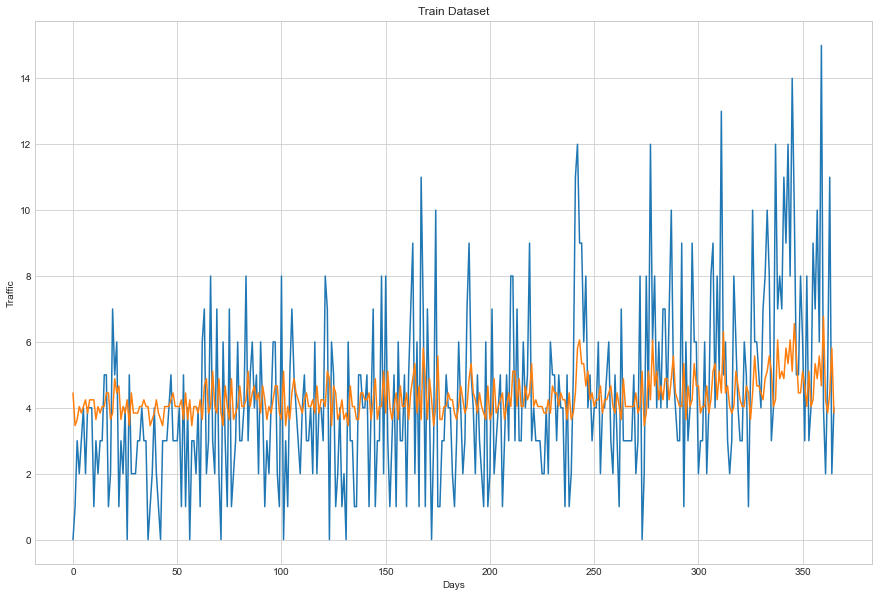

In [92]:
LL=trainY.T
fig, ax = plt.subplots()
ax.plot(LL)
ax.plot(trainPredict)
plt.title("Train Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

Text(0.5, 0, 'Days')

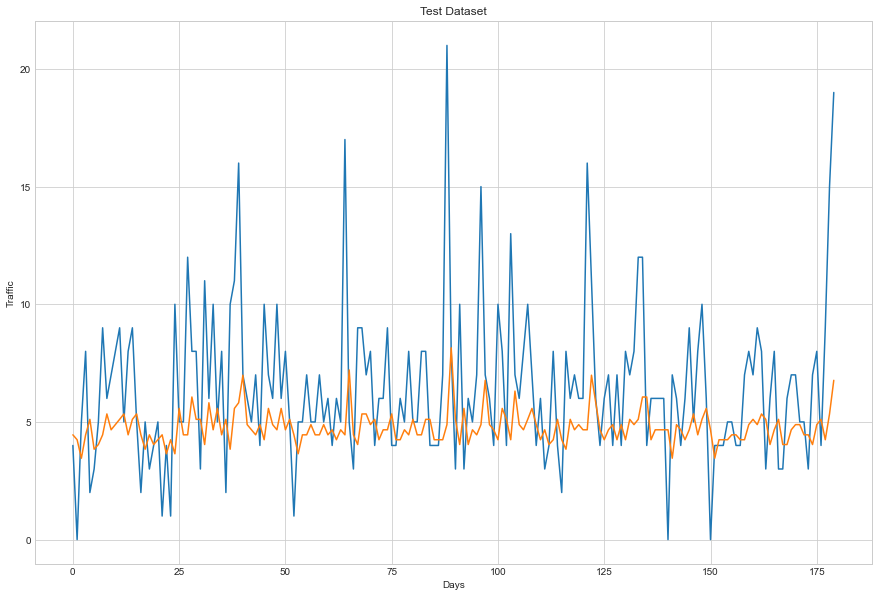

In [93]:
LL3=testY.T
fig, ax = plt.subplots()
ax.plot(LL3)
ax.plot(testPredict)
plt.title("Test Dataset")
plt.ylabel("Traffic")
plt.xlabel("Days")

**Let's also have a look at the type of views we have**
- Done in 03- Model Code